<a href="https://colab.research.google.com/github/nutworker/qM-AI-L/blob/L_test/email-subject/model-tuning/AESLC_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install git
!git clone https://github.com/ryanzhumich/AESLC

!pip install transformers
!pip install langchain_community
!pip install langchain
# !pip install unstructured
!pip install evaluate
!pip install rouge-score # Installing rouge-score library (https://pypi.org/project/rouge-score/)

# !pip install accelerate -U

!pip install transformers[torch]
!pip install sacrebleu

!pip install datasets nltk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (18304/18304), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.5 MB/s eta 0:00:00


In [3]:
repository_url = 'https://github.com/nutworker/qM-AI-L'
!git clone {repository_url}

Cloning into 'qM-AI-L'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (51/51), 874.14 KiB | 1.94 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
# Importing Libraries

# Data Handling
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import seaborn as sns

from datasets import load_metric
from datasets import Dataset
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# # Statistics & Mathematics
# import scipy.stats as stats
# # import statsmodels.api as sm
# from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
# import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00


In [6]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Trainer, TrainingArguments

In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import evaluate

In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader

In [9]:
# from langchain_community.document_loaders import GenericLoader
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader


In [10]:
from langchain.document_loaders.text import TextLoader


In [11]:
seed = 42
colormap = 'cividis'
template = 'plotly_dark'

In [12]:
#Function to get folder lenghts

def get_folder_lengths(base_folder):
    folder_lengths = {}
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if os.path.isdir(folder_path):
            num_files = len(os.listdir(folder_path))
            folder_lengths[folder_name] = num_files
    return folder_lengths


In [13]:
# Check size of raw datafiles

base_folder = '/content/AESLC/enron_subject_line'
folder_lengths = get_folder_lengths(base_folder)

for folder, length in folder_lengths.items():
    print(f"The folder '{folder}' contains {length} files.")

The folder 'train' contains 14436 files.
The folder 'dev' contains 1960 files.
The folder 'test' contains 1906 files.


In [14]:
folder_path = '/content/AESLC/enron_subject_line/train'

In [15]:
train_loader = DirectoryLoader(path=folder_path, glob="**/*.subject", silent_errors=True, show_progress=True, loader_cls=TextLoader)

In [16]:
train_loader

In [17]:
email_docs = train_loader.load()

100%|██████████| 14436/14436 [00:07<00:00, 1833.29it/s]


In [18]:
len(email_docs), type(email_docs)

(14436, list)

In [19]:
email_docs[0]

Document(metadata={'source': '/content/AESLC/enron_subject_line/train/hodge-j_inbox_221.subject'}, page_content='John,  Can you get me a fixed price for the following volumes delivered to the WGL citygate for these months?\nDec. 2001\t22,800 MMBtu per month Jan. 2002\t26,600 MMBtu per month Feb. 2002\t22,800 MMBtu per month Mar.\n2002\t22,800 MMBtu per month  Thank you\n\n@subject\nFirm fixed price for WGL delivered gas')

In [20]:
email_docs[0].page_content

'John,  Can you get me a fixed price for the following volumes delivered to the WGL citygate for these months?\nDec. 2001\t22,800 MMBtu per month Jan. 2002\t26,600 MMBtu per month Feb. 2002\t22,800 MMBtu per month Mar.\n2002\t22,800 MMBtu per month  Thank you\n\n@subject\nFirm fixed price for WGL delivered gas'

In [21]:
email_docs[0].metadata,

({'source': '/content/AESLC/enron_subject_line/train/hodge-j_inbox_221.subject'},)

In [22]:
email_docs[0].metadata['source']

'/content/AESLC/enron_subject_line/train/hodge-j_inbox_221.subject'

In [23]:
text_data = [doc.page_content for doc in email_docs]

In [24]:
text_data[0]

'John,  Can you get me a fixed price for the following volumes delivered to the WGL citygate for these months?\nDec. 2001\t22,800 MMBtu per month Jan. 2002\t26,600 MMBtu per month Feb. 2002\t22,800 MMBtu per month Mar.\n2002\t22,800 MMBtu per month  Thank you\n\n@subject\nFirm fixed price for WGL delivered gas'

In [25]:
def load_and_process_directory(directory_path):
    # Initialize the DirectoryLoader
    train_loader = DirectoryLoader(path=folder_path, glob="**/*.subject", silent_errors=True, show_progress=True, loader_cls=TextLoader)
    email_docs = train_loader.load()

    # Extract and process content from documents
    data = []

    for doc in email_docs:
      extracted_parts = split_text_into_parts(doc.page_content)
      for part in extracted_parts:
          data.append({
              'source': extract_file_name(doc.metadata.get('source', 'unknown')),
              'tag': part.get('tag', 'body'),
              'content': part['content']
          })


    # Create DataFrame
    df = pd.DataFrame(data)

    return df

In [26]:
def extract_lines_with_symbol(text, symbol):
    # Find all lines starting with the symbol and extract the tag and content
    pattern = re.compile(rf'^{re.escape(symbol)}(\w+)\n(.*)', re.MULTILINE)
    matches = pattern.findall(text)

    return {tag: content.strip() for tag, content in matches}

In [27]:
text_data[2]

'Critical Migration Information:  1.\nYour scheduled Outlook Migration Date is THE EVENING OF : May 3rd 2.\nYou need to press the "Save My Data" button (only once) to send us your pre-migration information.\n3.\nYou must be connected to the network before you press the button.\n4.\nIf a POP-UP BOX appears, prompting you to "ABORT, CANCEL OR TRUST SIGNER" please  select TRUST SIGNER.\n5.\nAny information you Add to your Personal Address Book, Journal or calendar after you click on the button will need to be manually re-added into Outlook after you have been migrated.\n6.\nClicking this button does not complete your migration to Outlook.\nYour migration will be completed  the evening of your migration date.\nFailure to click on the button means you WILL NOT get your Calendar, Contacts, Journal and ToDo information imported into Outlook the day of your migration and could result in up to a 2 week delay to restore this information.\nIf you encounter any errors please contact the resolution

In [28]:
#
def split_text_into_parts(text):
    # Split the text into parts as per the criteria
    pattern = re.compile(r'(@\w+)\n')
    parts = pattern.split(text)

    result = []
    current_part = {'tag': 'body', 'content': parts[0].strip()}
    result.append(current_part)

    for i in range(1, len(parts), 2):
        tag = parts[i][1:]  # Remove the @ symbol
        content = parts[i + 1].strip() if i + 1 < len(parts) else ''
        result.append({'tag': tag, 'content': content})

    return result


In [29]:
split_text_into_parts(text_data[2])

[{'tag': 'body',
  'content': 'Critical Migration Information:  1.\nYour scheduled Outlook Migration Date is THE EVENING OF : May 3rd 2.\nYou need to press the "Save My Data" button (only once) to send us your pre-migration information.\n3.\nYou must be connected to the network before you press the button.\n4.\nIf a POP-UP BOX appears, prompting you to "ABORT, CANCEL OR TRUST SIGNER" please  select TRUST SIGNER.\n5.\nAny information you Add to your Personal Address Book, Journal or calendar after you click on the button will need to be manually re-added into Outlook after you have been migrated.\n6.\nClicking this button does not complete your migration to Outlook.\nYour migration will be completed  the evening of your migration date.\nFailure to click on the button means you WILL NOT get your Calendar, Contacts, Journal and ToDo information imported into Outlook the day of your migration and could result in up to a 2 week delay to restore this information.\nIf you encounter any errors

In [30]:
def extract_file_name(file_path):
    # Regex to extract the file name without the extension
    pattern = re.compile(r'/([^/]+)\.[^.]+$')
    match = pattern.search(file_path)
    if match:
        return match.group(1)
    return None

In [31]:
emails_df = load_and_process_directory(folder_path)

100%|██████████| 14436/14436 [00:03<00:00, 4427.57it/s]


In [32]:
emails_df#.head(10)

,source,tag,content
0,hodge-j_inbox_221,body,"John, Can you get me a fixed price for the fo..."
1,hodge-j_inbox_221,subject,Firm fixed price for WGL delivered gas
2,beck-s_sent_890,body,I will be in the Calgary office with Peggy Hed...
3,beck-s_sent_890,subject,In Calgary Office - February 7 and 8
4,keavey-p_inbox_143,body,Critical Migration Information: 1.\nYour sche...
...,...,...,...
28869,salisbury-h_inbox_989,subject,"Informational Brown-Bag, Tuesday, June 26th - ..."
28870,kitchen-l_inbox_20,body,**** Please do not reply to this email.\nThe c...
28871,kitchen-l_inbox_20,subject,Change DNS (Domain Name Server) Confirmation
28872,jones-t_sent_5854,body,Mark Taylor has asked me to prepare an NDA for...


In [33]:
emails_df['tag'].unique()

array(['body', 'subject', 'ENRON_DEVELOPMENT', 'EES'], dtype=object)

In [34]:
emails_df

,source,tag,content
0,hodge-j_inbox_221,body,"John, Can you get me a fixed price for the fo..."
1,hodge-j_inbox_221,subject,Firm fixed price for WGL delivered gas
2,beck-s_sent_890,body,I will be in the Calgary office with Peggy Hed...
3,beck-s_sent_890,subject,In Calgary Office - February 7 and 8
4,keavey-p_inbox_143,body,Critical Migration Information: 1.\nYour sche...
...,...,...,...
28869,salisbury-h_inbox_989,subject,"Informational Brown-Bag, Tuesday, June 26th - ..."
28870,kitchen-l_inbox_20,body,**** Please do not reply to this email.\nThe c...
28871,kitchen-l_inbox_20,subject,Change DNS (Domain Name Server) Confirmation
28872,jones-t_sent_5854,body,Mark Taylor has asked me to prepare an NDA for...


In [35]:
pivot_df = emails_df.pivot(index='source', columns='tag', values='content').reset_index()

In [36]:
pivot_df

tag,source,EES,ENRON_DEVELOPMENT,body,subject
0,allen-p_inbox_20,NaN,NaN,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement
1,allen-p_inbox_28,NaN,NaN,Phillip & Keith Attached is the first draw re...,Bishops Corner
2,allen-p_inbox_63,NaN,NaN,Your Internet Banking accounts are now setup a...,Internet Banking
3,allen-p_inbox_64,NaN,NaN,To our IBS Customers that are still hanging in...,Internet Banking
4,allen-p_inbox_65,NaN,NaN,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories
...,...,...,...,...,...
14431,zufferli-j_inbox_43,NaN,NaN,This email is acknowledgement from the Power P...,Power Pool
14432,zufferli-j_inbox_44,NaN,NaN,This email is acknowledgement from the Power P...,Power Pool of Alberta
14433,zufferli-j_inbox_46,NaN,NaN,"John, Further to the voice message that I lef...",Enron Security
14434,zufferli-j_inbox_8,NaN,NaN,Make sure that all curves are downloaded by th...,Simulation Curves


In [37]:
desired_columns = ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2']
pivot_df = pivot_df.reindex(columns=desired_columns)
pivot_df

tag,source,body,subject,ann0,ann1,ann2
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN
...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN


In [38]:
pivot_df['body']

0        Greg/Phillip,  Attached is the Grande Communic...
1        Phillip & Keith  Attached is the first draw re...
2        Your Internet Banking accounts are now setup a...
3        To our IBS Customers that are still hanging in...
4        Phillip Good Morning!\nI hope you had a wonder...
                               ...                        
14431    This email is acknowledgement from the Power P...
14432    This email is acknowledgement from the Power P...
14433    John,  Further to the voice message that I lef...
14434    Make sure that all curves are downloaded by th...
14435    John:  Do you need Accumap day one?\nCarmen sa...
Name: body, Length: 14436, dtype: object

In [39]:
len(pivot_df['body'][2].split())

250

In [40]:
pivot_df['body_wcount'] = [len(x.split()) for x in pivot_df['body']]

In [41]:
pivot_df['subj_wcount'] = [len(x.split()) for x in pivot_df['subject']]

In [42]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4
...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2


In [43]:
def extract_sentences(text):
    # Remove control characters
    text = re.sub(r'[\r\n\t]', ' ', text)

    # Split the text into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    # Clean each sentence
    cleaned_sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return cleaned_sentences

In [44]:
pivot_df['body'][0]

'Greg/Phillip,  Attached is the Grande Communications Service Agreement.\nThe business points can be found in Exhibit C.  I Can get the Non-Disturbance agreement after it has been executed by you and Grande.\nI will fill in the Legal description of the property one I have received it.\nPlease execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.\n<<Bishopscontract.doc>>'

In [45]:
extract_sentences(pivot_df['body'][0])

['Greg/Phillip,  Attached is the Grande Communications Service Agreement.',
 'The business points can be found in Exhibit C.',
 'I Can get the Non-Disturbance agreement after it has been executed by you and Grande.',
 'I will fill in the Legal description of the property one I have received it.',
 'Please execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.',
 '<<Bishopscontract.doc>>']

In [46]:
def remove_special_characters(text):
    # Remove all special characters except periods
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)
    return cleaned_text

remove_special_characters(pivot_df['body'][0])

'GregPhillip  Attached is the Grande Communications Service Agreement.\nThe business points can be found in Exhibit C.  I Can get the NonDisturbance agreement after it has been executed by you and Grande.\nI will fill in the Legal description of the property one I have received it.\nPlease execute and send to  Grande Communications 401 Carlson Circle San Marcos Texas 78666 Attention Hunter Williams.\nBishopscontract.doc'

In [47]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters except periods and newlines
    text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
clean_text(pivot_df['body'][0])

'gregphillip attached is the grande communications service agreement. the business points can be found in exhibit c. i can get the nondisturbance agreement after it has been executed by you and grande. i will fill in the legal description of the property one i have received it. please execute and send to grande communications 401 carlson circle san marcos texas 78666 attention hunter williams. bishopscontract.doc'

In [48]:
pivot_df['cleaned_emails'] = pivot_df['body'].apply(clean_text)

In [49]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount,cleaned_emails
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2,gregphillip attached is the grande communicati...
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2,phillip keith attached is the first draw reque...
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2,your internet banking accounts are now setup a...
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2,to our ibs customers that are still hanging in...
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4,phillip good morning i hope you had a wonderfu...
...,...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2,this email is acknowledgement from the power p...
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4,this email is acknowledgement from the power p...
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2,john further to the voice message that i left ...
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2,make sure that all curves are downloaded by th...


Text(0, 0.5, 'Frequency')

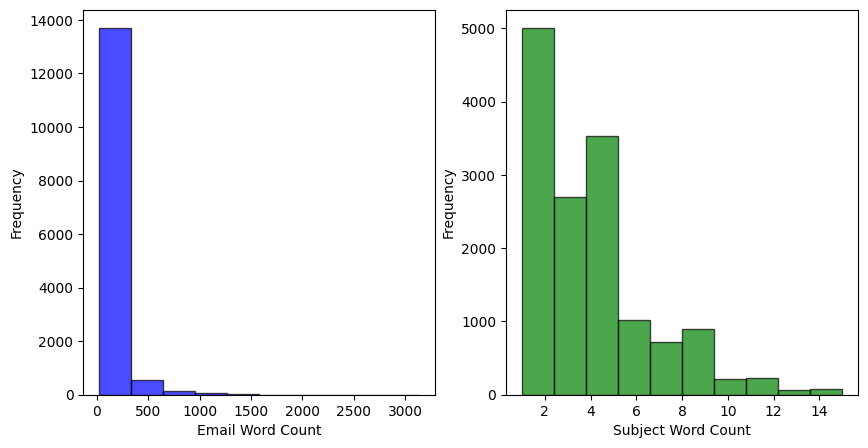

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(pivot_df['body_wcount'], bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Email Word Count')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(pivot_df['subj_wcount'], bins=10, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Subject Word Count')
plt.ylabel('Frequency')


In [51]:
def plot_correlation(df, title, dataset, width, height, fontsize):
    """
    Plot a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    title (str): Title of the plot.
    dataset (str): Name of the dataset.
    width (int): Width of the plot.
    height (int): Height of the plot.
    fontsize (int): Font size for the plot labels.
    """
    plt.figure(figsize=(width / 100, height / 100))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title(f'{title} - {dataset}', fontsize=fontsize)
    plt.xticks(rotation=45, fontsize=fontsize-2)
    plt.yticks(rotation=0, fontsize=fontsize-2)
    plt.show()

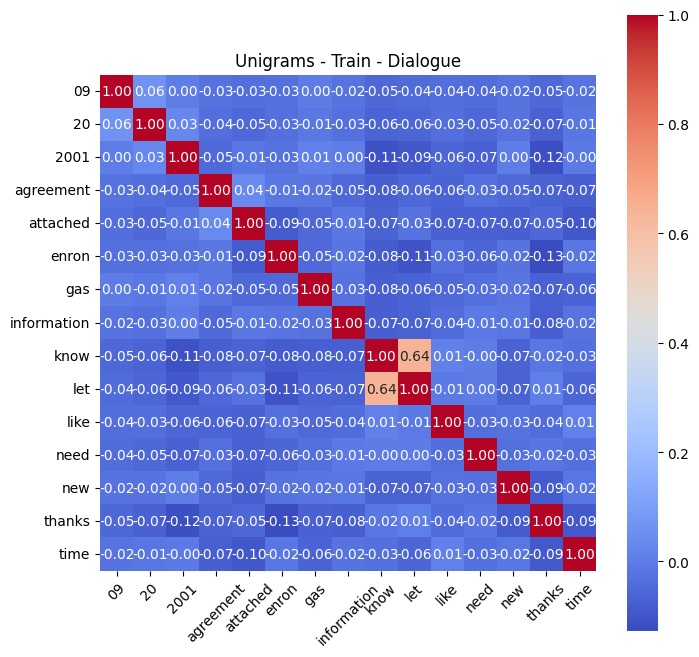

In [52]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'])
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Dialogue', 800, 800, 12)

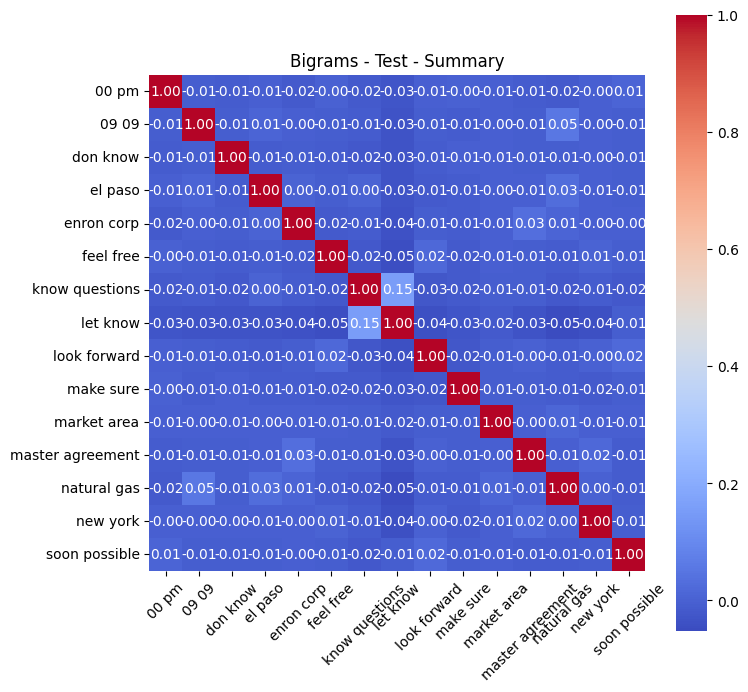

In [53]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Summary', 800, 800, 12)

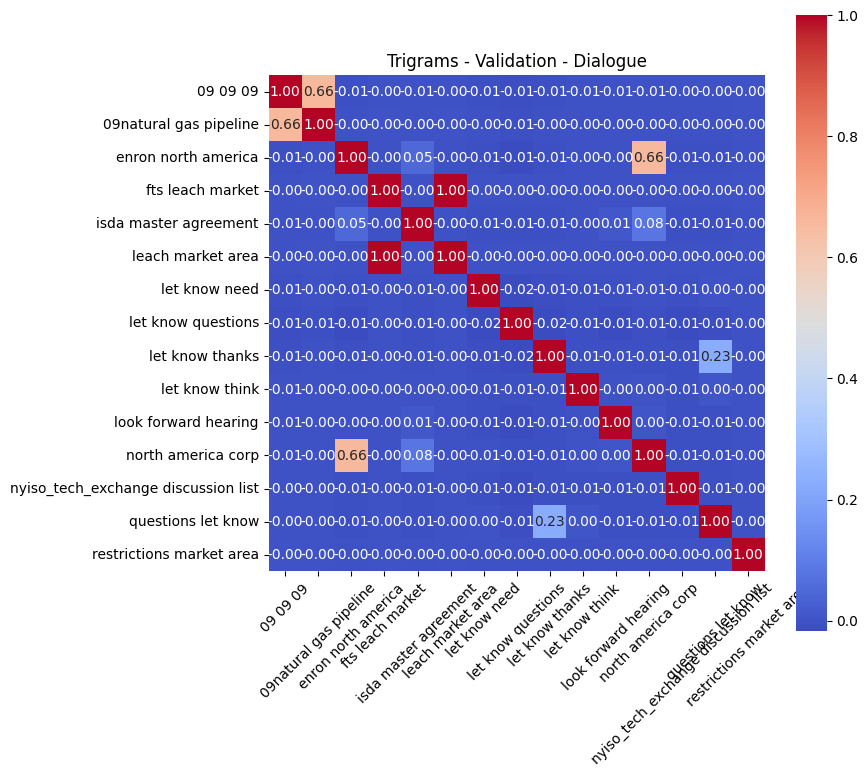

In [54]:

vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Dialogue', 800, 800, 12)

In [55]:
nan_rows = pivot_df[pivot_df.isna().any(axis=1)]


In [56]:
len(pivot_df['body'][0])


429

In [57]:
pivot_df['body'][0][0:2]

'Gr'

In [58]:
pivot_df['body'][1]

'Phillip & Keith  Attached is the first draw request, I will need some of these funds immediately.\nI think checks out of Bishops Corner, L.P. may be the easiest, or you can wire money to me and I can write the checks when needed.\nPlease let me know how you wish to handle this and I will proceed.\nAdditionally, it is getting close to closing.\nI will need to get contracts signed at this point as soon as possible.\nWe can handle this in two ways.\nI prefer that you elect me as a Vice - President of the General Partner and then I will sign all documents, or I can Federal Express contracts (this is more difficult).\nI have a funeral at 10:00 and I will be back about 1:00.\nI look forward to hearing from you.\nGreg     - Draw # 1 - 10.25.01.xls'

In [59]:
# Assuming your DataFrame is named 'data' with columns 'text' and 'label' (adjust names if needed)
text_data = pivot_df['body'].tolist()
summary_data = pivot_df['subject'].tolist()

In [60]:
len(text_data), len(summary_data)

(14436, 14436)

In [61]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount,cleaned_emails
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2,gregphillip attached is the grande communicati...
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2,phillip keith attached is the first draw reque...
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2,your internet banking accounts are now setup a...
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2,to our ibs customers that are still hanging in...
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4,phillip good morning i hope you had a wonderfu...
...,...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2,this email is acknowledgement from the power p...
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4,this email is acknowledgement from the power p...
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2,john further to the voice message that i left ...
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2,make sure that all curves are downloaded by th...


**Test Train Split**

In [62]:
train_df, test_df = train_test_split(pivot_df, test_size=0.2, random_state=42)

In [63]:
train_df.shape, test_df.shape

((11548, 9), (2888, 9))

In [64]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [65]:
train_dataset, test_dataset

(Dataset({
     features: ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2', 'body_wcount', 'subj_wcount', 'cleaned_emails', '__index_level_0__'],
     num_rows: 11548
 }),
 Dataset({
     features: ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2', 'body_wcount', 'subj_wcount', 'cleaned_emails', '__index_level_0__'],
     num_rows: 2888
 }))

In [66]:
#create a subset of dataset
train_dataset = train_dataset.filter(lambda example, index: index % 5 == 0, with_indices=True)
test_dataset = train_dataset.filter(lambda example, index: index % 5 == 0, with_indices=True)

Filter:   0%|          | 0/11548 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2310 [00:00<?, ? examples/s]

In [67]:
train_dataset.shape, test_dataset.shape

((2310, 10), (462, 10))

In [68]:
train_dataset['cleaned_emails'][0]

'met early this morning with jack steward pres. of cma and keith mccrea lawyer for cma to follow up on the meeting that steve and i had with them regarding the proposal ken lay was pushing last week they like taking tx out of the mou they like getting dwr out of the power purchase business and they think that edisons mou needs a little haircut. mccrea pushed back initially on corenoncore why should it be mandatory to go the market but after much discussion they agreed that our idea for corenoncore has a lot of merit. our idea is that 1 the corenoncore would take effect in 1824 months when the markets settle and prices come down 2 everyone core and noncore should pay for dwrs past purchases since everyone consumed it 3 core customers should take iou generation qfs and dwr contracts which eliminates the cores net short position and 4 noncore would go to market and would not have to pay for any of dwrs going forward costs since core gets them in exchange for getting all the lowcost iou ge

**Load the pre-trained FLAN-T5 model and its tokenizer directly from HuggingFace. This is a small version of FLAN-T5. FLAN-T5 was released in the paper Scaling Instruction-Finetuned Language Models - it is an enhanced version of T5 that has been finetuned in a mixture of tasks. Setting torch_dtype=torch.bfloat16 specifies the memory type to be used by this model.**

In [69]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer


In [70]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"Trainable model parameters: {trainable_model_params}\nAll model parameters: {all_model_params}\nPercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"



In [71]:
flan_t5_base_original_model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base', torch_dtype=torch.bfloat16)
flan_t5_base_tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')

print("For Model : FLAN-T5-Base \n",print_number_of_trainable_model_parameters(flan_t5_base_original_model))

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

For Model : FLAN-T5-Base 
 Trainable model parameters: 247577856
All model parameters: 247577856
Percentage of trainable model parameters: 100.00%


In [72]:
flan_t5_small_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small", torch_dtype=torch.bfloat16)
flan_t5_small_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

print("For Model : Flan-t5-small \n",print_number_of_trainable_model_parameters(flan_t5_small_model))

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

For Model : flan-t5-small 
 Trainable model parameters: 76961152
All model parameters: 76961152
Percentage of trainable model parameters: 100.00%


In [73]:
# flan-t5-base vs. flan-t5-small parameters
247577856-76961152

170616704

# **Test the Model with Zero Shot Inferencing**

**Using a pre-trained model from Hugging Face/sources - FLAN-T5-Base .**

In [76]:
index = 10

email = train_dataset['cleaned_emails'][index]
subject = train_dataset['subject'][index]

prompt = f"""
Generate the subject line for the following email.

Email:
{email}

Subject:
"""

inputs = flan_t5_base_tokenizer(prompt, return_tensors='pt')

# Move input tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(flan_t5_base_original_model.device) for k, v in inputs.items()}


output = flan_t5_base_tokenizer.decode(
    flan_t5_base_original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE ORIGINAL HUMAN ANNOTED SUBJECT LINE :\n{subject}\n')
print(dash_line)
print(f'FLAN-T5 MODEL GENERATION - ZERO SHOT SUBJECT LINE:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Generate the subject line for the following email.

Email:
many of you have asked about procedures to evaluate employee performance. we are finalizing a performance process designed to track and provide feedback on individual accomplishments for the benefit of each employee the company and the unsecured creditors committee. a very simple and straightforward online performance assessment system pas will allow us to automate parts of the process. pas will open next week on monday may 13 and remain open through friday may 24 2002. as an employee of a debtor company you should access the system and complete your self assessment by friday may 17 2002. your supervisor will review and approve submitted accomplishments and schedule a facetoface meeting to discuss your contributions offer feedback set priorities for the upcoming period discuss challenges and potential development o

**Using a pre-trained model from Hugging Face etc- FLAN-T5-SMALL .**

In [77]:
inputs = flan_t5_small_tokenizer(prompt, return_tensors='pt')

# Move input tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# inputs = {k: v.to(device) for k, v in inputs.items()}


output = flan_t5_small_tokenizer.decode(
    flan_t5_small_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE ORIGINAL HUMAN ANNOTED SUBJECT LINE :\n{subject}\n')
print(dash_line)
print(f'FLAN-T5-SMALL MODEL GENERATION - ZERO SHOT SUBJECT LINE:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Generate the subject line for the following email.

Email:
many of you have asked about procedures to evaluate employee performance. we are finalizing a performance process designed to track and provide feedback on individual accomplishments for the benefit of each employee the company and the unsecured creditors committee. a very simple and straightforward online performance assessment system pas will allow us to automate parts of the process. pas will open next week on monday may 13 and remain open through friday may 24 2002. as an employee of a debtor company you should access the system and complete your self assessment by friday may 17 2002. your supervisor will review and approve submitted accomplishments and schedule a facetoface meeting to discuss your contributions offer feedback set priorities for the upcoming period discuss challenges and potential development o

**By testing with various models with the zero shot inferencing, we can see that the model struggles to extract the same subject line compared to the baseline subject, but it does pull out some important information from the email which indicates the models can be fine-tuned to the task at hand.**

# **Performing Full Fine-Tuning using FLAN-T5 BASE MODEL**

In [78]:
start_prompt = 'Generate the subject line for the following email.\n\nEmail:'
end_prompt = '\nSubject:\n'
start_prompt + email + end_prompt
print(start_prompt)
print(email)
print(end_prompt)

Generate the subject line for the following email.

Email:
many of you have asked about procedures to evaluate employee performance. we are finalizing a performance process designed to track and provide feedback on individual accomplishments for the benefit of each employee the company and the unsecured creditors committee. a very simple and straightforward online performance assessment system pas will allow us to automate parts of the process. pas will open next week on monday may 13 and remain open through friday may 24 2002. as an employee of a debtor company you should access the system and complete your self assessment by friday may 17 2002. your supervisor will review and approve submitted accomplishments and schedule a facetoface meeting to discuss your contributions offer feedback set priorities for the upcoming period discuss challenges and potential development opportunities and if applicable confirm your quarterly retention payout and project a target for the upcoming quarte

In [79]:
# Tokenization for FLAN-T5 model
def flan_t5_base_tokenize_function(example):
    start_prompt = 'Generate the subject line for the following email.\n\nEmail:'
    end_prompt = '\nSubject:\n'
    prompt = [start_prompt + email + end_prompt for email in example["cleaned_emails"]]
    example['input_ids'] = flan_t5_base_tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = flan_t5_base_tokenizer(example["subject"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_train_datasets = train_dataset.map(flan_t5_base_tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(flan_t5_base_tokenize_function, batched=True)


Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [ ]:
# tokenized_train_datasets = tokenized_train_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)
# tokenized_test_datasets = tokenized_test_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

In [ ]:
tokenized_train_datasets, tokenized_test_datasets

**FLAN-T5 BASE - Fine-Tune the Model with the Preprocessed Tokenised Dataset utiliing the built-in Hugging Face Trainer class. Then compare it with reference to the original model.**

flan_t5_base_original_model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base', torch_dtype=torch.bfloat16)
flan_t5_base_tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')

In [80]:
# # Tokenization
# def preprocess_data(examples):
#     inputs = ["generate subject line: " + email for email in examples['cleaned_emails']]
#     model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(examples['subject'], max_length=128, truncation=True, padding="max_length")

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# train_dataset = train_dataset.map(preprocess_data, batched=True)
# test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
trainer = Trainer(
    model=flan_t5_base_original_model ,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
)

# Train the model
trainer.train()



Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

FLAN-T5 SMALL - Fine-Tune the Model with the Preprocessed Tokenised Dataset utiliing the built-in Hugging Face Trainer class. Then compare it with reference to the original model.

flan_t5_small_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small", torch_dtype=torch.bfloat16)
flan_t5_small_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

In [81]:
# Tokenization for FLAN-T5 SMALL model
def flan_t5_small_tokenize_function(example):
    start_prompt = 'Generate the subject line for the following email.\n\nEmail:'
    end_prompt = '\nSubject:\n'
    prompt = [start_prompt + email + end_prompt for email in example["cleaned_emails"]]
    example['input_ids'] = flan_t5_small_tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = flan_t5_small_tokenizer(example["subject"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_train_datasets = train_dataset.map(flan_t5_small_tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(flan_t5_small_tokenize_function, batched=True)

Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [82]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
trainer = Trainer(
    model=flan_t5_small_model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,40.390500,37.055195
2,34.457000,36.427490
3,34.215000,36.414501


TrainOutput(global_step=1734, training_loss=36.069204152249135, metrics={'train_runtime': 881.5964, 'train_samples_per_second': 7.861, 'train_steps_per_second': 1.967, 'total_flos': 1288221197598720.0, 'train_loss': 36.069204152249135, 'epoch': 3.0})

In [86]:
# Save the model checkpoint
flan_t5_small_model.save_pretrained('./results/Flan_T5_small_model')
flan_t5_small_tokenizer.save_pretrained('./results/Flan_T5_small_model')

# Define and save the generation configuration
generation_config = GenerationConfig(
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2
)

generation_config.save_pretrained('./results/Flan_T5_small_model')

In [ ]:
AutoModelForSeq2SeqLM
AutoTokenizer

In [90]:
# Load the trained Flan T5 Small fine tuned model
flan_T5_small_model_directory = '/content/results/Flan_T5_small_model'
flan_T5_small_tokenizer = AutoTokenizer.from_pretrained(flan_T5_small_model_directory)
flan_T5_small_model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(flan_T5_small_model_directory)

In [95]:
emails_for_score = tokenized_test_datasets[0:10]['cleaned_emails']
original_subjects = tokenized_test_datasets[0:10]['subject']

In [97]:
flan_T5small_subjects = []
finetuned_flan_T5small_subjects = []

for _, cleaned_emails in enumerate(emails_for_score):
    prompt = f"""
    Generate the subject line for the following email.

    Email:
    {email}

    Subject:
    """
    # Tokenize the input and move to the same device as the model
    inputs = flan_t5_small_tokenizer(prompt, return_tensors='pt').to(flan_T5_small_model_finetuned.device) # Move inputs to the same device as the fine-tuned model

    # Add the decoder_start_token_id to the generation configuration
    generation_config = GenerationConfig(max_new_tokens=200,
        decoder_start_token_id=flan_T5_small_tokenizer.bos_token_id if flan_T5_small_tokenizer.bos_token_id is not None else flan_T5_small_tokenizer.eos_token_id
    )



    # Generate subject using the original model
    # Make sure flan_t5_small_model is on the same device as flan_T5_small_model_finetuned
    flan_t5_small_model = flan_t5_small_model.to(flan_T5_small_model_finetuned.device)
    original_model_outputs = flan_t5_small_model.generate(**inputs, generation_config=generation_config)
    original_model_subject_output = flan_t5_small_tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    flan_T5small_subjects.append(original_model_subject_output)

    # Generate subject using the finetuned model
    trained_flan_t5_outputs = flan_T5_small_model_finetuned.generate(**inputs, generation_config=generation_config)
    instruct_model_text_output = flan_T5_small_tokenizer.decode(trained_flan_t5_outputs[0], skip_special_tokens=True)
    finetuned_flan_T5small_subjects.append(instruct_model_text_output)

zipped_summaries = list(zip(original_subjects, flan_T5small_subjects, finetuned_flan_T5small_subjects))

Flan_T5_Small_Subjects_df = pd.DataFrame(zipped_summaries, columns = ['Original_subjects', 'Flan_T5s_subjects', 'Finetuned_Flan_T5s_subjects'])
Flan_T5_Small_Subjects_df

,Original_subjects,Flan_T5s_subjects,Finetuned_Flan_T5s_subjects
0,Follow-up Meeting this Morning w/CMA,,
1,Engineering Standards for Measurement,,
2,Performance Process for All Employees in Debto...,,
3,Leaf River Information for Board Presentation,,
4,"Goldman, Sachs & Co. ""Cllient Access Agreement""",,
5,Enron Forward/Assignment confirms,,
6,Australian Master and Brokerage agreements,,
7,Counselling,,
8,UNCF Walk Collections,,
9,PB-KBB - Construction of Cavern #1 (Napoleonvi...,,


In [ ]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
# from datasets import Dataset


# # Initialize tokenizer and model
# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# T5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [ ]:
def tokenize_function(example):
    start_prompt = 'Generate the subject line for the following email.\n\n'
    end_prompt = '\n\Subject: '
    prompt = [start_prompt + email + end_prompt for email in example["cleaned_emails"]]
    # Tokenize the input_ids - do not flatten
    example['input_ids'] = [tokenizer(p, padding="max_length", truncation=True, return_tensors="pt").input_ids[0] for p in prompt]
    # Tokenize the labels - do not flatten
    example['labels'] = [tokenizer(s, padding="max_length", truncation=True, return_tensors="pt").input_ids[0] for s in example["subject"]]

    return example

In [ ]:
# output_dir = f'./email-Subject-training-{str(int(time.time()))}'

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     learning_rate=1e-5,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_steps=30,
#     evaluation_strategy='epoch',
#     per_device_train_batch_size=4,  # Reduced batch size
#     # max_steps=1
# )

# # training_args = TrainingArguments(
# #     output_dir='./results',
# #     evaluation_strategy='epoch',
# #     learning_rate=1e-5,
# #     per_device_train_batch_size=4,
# #     per_device_eval_batch_size=4,
# #     num_train_epochs=3,
# #     weight_decay=0.01,
# # )

# trainer = Trainer(
#     model=flan_t5_base_original_model,
#     args=training_args,
#     train_dataset=tokenized_train_datasets,
#     eval_dataset=tokenized_test_datasets
# )

# trainer.train()

In [ ]:
# # Generate subject lines for the test set
# def generate_subject_line(email_body):
#     inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
#     # Move inputs to the same device as the model
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}
#     outputs = model.generate(inputs.input_ids, max_length=128, num_beams=4, early_stopping=True)
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)

# test_df['generated_subject_line'] = test_df['cleaned_emails'].apply(generate_subject_line)

# Generate subject lines for the test set
def generate_subject_line(email_body):
    inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Access input_ids as a key in the dictionary
    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_df['generated_subject_line'] = test_df['cleaned_emails'].apply(generate_subject_line)

# **t5-small Evaluation**

In [ ]:
!pip install nltk
import nltk
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [ ]:
# Download the 'punkt' resource
nltk.download('punkt')
nltk.download('wordnet') # Download WordNet

from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # Tokenize the input for METEOR
    true_subject_tokens = nltk.word_tokenize(true_subject)
    generated_subject_tokens = nltk.word_tokenize(generated_subject)

    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject_tokens], generated_subject_tokens) # Pass tokenized input

    # SACREBLEU - Use import sacrebleu directly
    sacre_bleu_score = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu_score # Return the score, not the module

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject'], row['generated_subject_line']), axis=1))

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean() # Now you should be able to calculate the mean

print(f'Average ROUGE-L: {average_rougeL:.4f}')
print(f'Average METEOR: {average_meteor:.4f}')
print(f'Average SACREBLEU: {average_sacrebleu:.4f}')

# **Pretrained('facebook/bart-base')**

In [98]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

In [99]:
# # Convert DataFrame to Dataset
# train_dataset = Dataset.from_pandas(train_df)
# test_dataset = Dataset.from_pandas(test_df)

# Initialize tokenizer and model
facebook_bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
facebook_bart_base_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [100]:
print("For Model : facebook_bart_base_model \n",print_number_of_trainable_model_parameters(facebook_bart_base_model))

For Model : facebook_bart_base_model 
 Trainable model parameters: 139420416
All model parameters: 139420416
Percentage of trainable model parameters: 100.00%


In [101]:
prompt = f"""
Generate the subject line for the following email.

Email:
{email}

Subject:
"""

inputs = facebook_bart_tokenizer(prompt, return_tensors='pt')

# Move input tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(facebook_bart_base_model.device) for k, v in inputs.items()}

outputs = facebook_bart_base_model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE ORIGINAL HUMAN ANNOTED SUBJECT LINE :\n{subject}\n')
print(dash_line)
print(f'FB BART MODEL GENERATION - ZERO SHOT SUBJECT LINE:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Generate the subject line for the following email.

Email:
eric as we discussed we need to take the most recent invoice from pbkbb the contractor that is responsible for injection of gas into napoleonville and have them bifurcate the bill into prebankruptcy and postbankruptcy amounts using 122 as the date of bankruptcy. in the meantime please prepare a cash use request form for the postbankruptcy amount doug sewell can assist you on this for consideration by the cash committee. chip please confirm that this is the appropriate course of action also please forward geralds draft of new agreement to pbkbb for their consideration along with any proposed changes to the scope of work description.

Subject:

---------------------------------------------------------------------------------------------------
BASELINE ORIGINAL HUMAN ANNOTED SUBJECT LINE :
Performance Process for All 

In [102]:

# Tokenization
def Tokenization_preprocess_data(examples):
    inputs = [prompt + email for email in examples['cleaned_emails']]
    model_inputs = facebook_bart_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Use facebook_bart_tokenizer as the target tokenizer
    with facebook_bart_tokenizer.as_target_tokenizer():
        labels = facebook_bart_tokenizer(examples['subject'], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(Tokenization_preprocess_data, batched=True)
test_dataset = test_dataset.map(Tokenization_preprocess_data, batched=True)

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy='epoch',
#     learning_rate=2e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3,
#     weight_decay=0.01,
# )


training_args = TrainingArguments(
    output_dir='./results',        # Directory to save the model checkpoints
    evaluation_strategy='steps',
    save_steps=500,               # Save checkpoint every 1000 steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
)

# Define Trainer
facebook_bart_base_model_trainer = Trainer(
    model=facebook_bart_base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
facebook_bart_base_model_trainer.train()


Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
200,7.010000,0.885521
400,0.353600,0.183391
600,0.220300,0.132789
800,0.154500,0.107520


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=867, training_loss=1.796934161906699, metrics={'train_runtime': 659.8423, 'train_samples_per_second': 10.503, 'train_steps_per_second': 1.314, 'total_flos': 2112736827801600.0, 'train_loss': 1.796934161906699, 'epoch': 3.0})

In [103]:
# Save the final model checkpoint
facebook_bart_base_model.save_pretrained('./results/FB_Bart_model')
facebook_bart_tokenizer.save_pretrained('./results/FB_Bart_model')

# Define and save the generation configuration
generation_config = GenerationConfig(
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2
)

generation_config.save_pretrained('./results/FB_Bart_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [104]:
cd /content

/content


In [105]:
# Define paths
logs_folder = '/content/logs'  # Adjust to your source folder
logs_git_folder = './content/qM-AI-L/email-subject/model-tuning/logs'  # Adjust to your repository folder

# Copy the folder
shutil.copytree(logs_folder, logs_git_folder)

'./content/qM-AI-L/email-subject/model-tuning/logs'

In [106]:
# Define paths
results_folder = '/content/results'  # Adjust to your source folder
results_git_folder = './content/qM-AI-L/email-subject/model-tuning/results'  # Adjust to your repository folder

# Copy the folder
shutil.copytree(results_folder, results_git_folder)

'./content/qM-AI-L/email-subject/model-tuning/results'

In [107]:
# Change directory to the cloned repository
os.chdir('./content/qM-AI-L')  # Adjust to your repository folder

# Configure Git (only needed once)
!git config --global user.email "mlreddy3082@gmail.com"
!git config --global user.name "Mlr9459"

# Add, commit, and push changes
!git add /content/qM-AI-L/email-subject/
!git commit -m "Add training outputs: model checkpoints, tokenizer, and generation configuration"
!git push origin master

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


**Evaluate the Model Quantitatively (with ROUGE Metric)
The ROUGE metric) helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.**

In [108]:
tokenized_train_datasets, tokenized_test_datasets

(Dataset({
     features: ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2', 'body_wcount', 'subj_wcount', 'cleaned_emails', '__index_level_0__', 'input_ids', 'labels'],
     num_rows: 2310
 }),
 Dataset({
     features: ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2', 'body_wcount', 'subj_wcount', 'cleaned_emails', '__index_level_0__', 'input_ids', 'labels'],
     num_rows: 462
 }))

In [109]:
tokenized_train_datasets[0:10]['cleaned_emails']

['met early this morning with jack steward pres. of cma and keith mccrea lawyer for cma to follow up on the meeting that steve and i had with them regarding the proposal ken lay was pushing last week they like taking tx out of the mou they like getting dwr out of the power purchase business and they think that edisons mou needs a little haircut. mccrea pushed back initially on corenoncore why should it be mandatory to go the market but after much discussion they agreed that our idea for corenoncore has a lot of merit. our idea is that 1 the corenoncore would take effect in 1824 months when the markets settle and prices come down 2 everyone core and noncore should pay for dwrs past purchases since everyone consumed it 3 core customers should take iou generation qfs and dwr contracts which eliminates the cores net short position and 4 noncore would go to market and would not have to pay for any of dwrs going forward costs since core gets them in exchange for getting all the lowcost iou g

In [110]:
emails_for_score = tokenized_test_datasets[0:10]['cleaned_emails']
human_annoted_subjects = tokenized_test_datasets[0:10]['subject']


In [111]:
facebook_bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
facebook_bart_base_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [112]:
model_directory = '/content/results/FB_Bart_model'
facebook_bart_tokenizer_trained = BartTokenizer.from_pretrained(model_directory)
facebook_bart_base_model_trained = BartForConditionalGeneration.from_pretrained(model_directory)

In [113]:
facebook_bart_subjects = []
trained_facebook_bart_subjects = []

for _, email in enumerate(emails_for_score):
    prompt = f"""
    Generate the subject line for the following email.

    Email:
    {email}

    Subject:
    """
    # Tokenize the input and move to the same device as the model
    inputs = facebook_bart_tokenizer(prompt, return_tensors='pt').to(facebook_bart_base_model.device)

    # Add the decoder_start_token_id to the generation configuration
    generation_config = GenerationConfig(
    max_new_tokens=200,
    decoder_start_token_id=facebook_bart_tokenizer.bos_token_id  # Add this line
    )



    # Generate subject using the original model
    original_model_outputs = facebook_bart_base_model.generate(**inputs, generation_config=generation_config)
    original_model_subject_output = facebook_bart_tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    facebook_bart_subjects.append(original_model_subject_output)

    trained_facebook_bart_outputs = facebook_bart_base_model_trained.generate(**inputs, generation_config=generation_config)
    instruct_model_text_output = facebook_bart_tokenizer_trained.decode(trained_facebook_bart_outputs[0], skip_special_tokens=True)
    trained_facebook_bart_subjects.append(instruct_model_text_output)

zipped_summaries = list(zip(human_annoted_subjects, facebook_bart_subjects, trained_facebook_bart_subjects))

df = pd.DataFrame(zipped_summaries, columns = ['human_annoted_subjects', 'facebook_bart_subjects', 'trained_facebook_bart_subjects'])
df

,human_annoted_subjects,facebook_bart_subjects,trained_facebook_bart_subjects
0,Follow-up Meeting this Morning w/CMA,� Generate the subject line for the follow...,Core Noncore
1,Engineering Standards for Measurement,Subject: Generate the subject line for t...,New Standards for Measurement
2,Performance Process for All Employees in Debto...,Generate the subject line for the follow...,HR Access
3,Leaf River Information for Board Presentation,Subject: Generate the subject line for ...,Board Meeting
4,"Goldman, Sachs & Co. ""Cllient Access Agreement""",Subject: Generate the subject line for t...,Goldman Sachs Agreement
5,Enron Forward/Assignment confirms,Generate the subject line for the follo...,Enron Forward
6,Australian Master and Brokerage agreements,Generate the subject line for the follo...,Enron Australia
7,Counselling,Generate the subject line for the follow...,Counselling
8,UNCF Walk Collections,Subject: Generate the subject line for...,UncF Walkathon
9,PB-KBB - Construction of Cavern #1 (Napoleonvi...,Generate the subject line for the follo...,Projects


In [126]:
!pip install rouge-score
from rouge_score import rouge_scorer
from rouge_score.scoring import BootstrapAggregator



In [127]:
# Calculate ROUGE scores for each pair of prediction and reference
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
aggregator = BootstrapAggregator() # Initialize aggregator

for prediction, reference in zip(facebook_bart_subjects, human_annoted_subjects[0:len(facebook_bart_subjects)]):
    score = scorer.score(reference, prediction)
    aggregator.add_scores(score) # Add scores to aggregator

# Aggregate the scores
original_model_results = aggregator.aggregate()

print(original_model_results)

{'rouge1': AggregateScore(low=Score(precision=0.016710055503380283, recall=0.23214285714285712, fmeasure=0.030957251090766382), mid=Score(precision=0.04198074292345794, recall=0.4648809523809524, fmeasure=0.06252371479992963), high=Score(precision=0.07324770418169407, recall=0.6786309523809524, fmeasure=0.09563812119224362)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.007492427865455125, recall=0.12857142857142856, fmeasure=0.01409090909090909), high=Score(precision=0.018999795039967203, recall=0.28107142857142847, fmeasure=0.03583333333333332)), 'rougeL': AggregateScore(low=Score(precision=0.017639682178854997, recall=0.24755952380952387, fmeasure=0.03133421241205894), mid=Score(precision=0.04187536777395571, recall=0.45595238095238094, fmeasure=0.06187822558905744), high=Score(precision=0.07294452149173748, recall=0.6892857142857143, fmeasure=0.09619063198958652))}


In [128]:
original_model_results = rouge.compute(
    predictions=facebook_bart_subjects,
    references=human_annoted_subjects[0:len(facebook_bart_subjects)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=trained_facebook_bart_subjects,
    references=human_annoted_subjects[0:len(trained_facebook_bart_subjects)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.06252371479992963, 'rouge2': 0.01409090909090909, 'rougeL': 0.06187822558905744, 'rougeLsum': 0.06115348980526484}
INSTRUCT MODEL:
{'rouge1': 0.365, 'rouge2': 0.13571428571428573, 'rougeL': 0.365, 'rougeLsum': 0.3716666666666667}


In [130]:
# Save the model locally
model_save_path = "./facebook_bart_base"
facebook_bart_base_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


NameError: name 'tokenizer' is not defined

In [ ]:
# Generate subject lines for the test set
def generate_subject_line(email_body):
    inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
    # Move inputs to the GPU if available
    inputs = {k: v.to(facebook_bart_base_model.device) for k, v in inputs.items()}
    # Access input_ids from the dictionary
    outputs = facebook_bart_base_model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_df['generated_subject_line'] = test_df['body'].apply(generate_subject_line)

In [ ]:
test_df

In [ ]:

import nltk
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # Tokenize the input for METEOR
    true_subject_tokens = nltk.word_tokenize(true_subject)
    generated_subject_tokens = nltk.word_tokenize(generated_subject)

    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject_tokens], generated_subject_tokens) # Pass tokenized input

    # SACREBLEU - Use import sacrebleu directly
    sacre_bleu_score = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu_score # Return the score, not the module

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject'], row['generated_subject_line']), axis=1))

In [ ]:

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean() # Now you should be able to calculate the mean

print(f'Average facebook_bart_base_model ROUGE-L: {average_rougeL:.4f}')
print(f'Average facebook_bart_base_model METEOR: {average_meteor:.4f}')
print(f'Average facebook_bart_base_model SACREBLEU: {average_sacrebleu:.4f}')

In [ ]:
import shutil
from google.colab import files

# Replace 'directory_name' with the name of your directory
shutil.make_archive('/content/facebook_bart_base_model', 'zip', 'facebook_bart_base_model')

In [ ]:
# files.download('facebook_bart_base_model.zip')

# **t5-base**

In [ ]:
# Define tokenizer and model t5-base
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")


In [ ]:
dataset = Dataset.from_pandas(pivot_df)

In [ ]:
dataset

In [ ]:
def preprocess_function(pivot_df):
    inputs = pivot_df['cleaned_emails']
    targets = pivot_df['subject']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
import shutil
from google.colab import files

# Replace 'directory_name' with the name of your directory
# shutil.make_archive('/content/fine_tuned_t5', 'zip', 'fine_tuned_t5')

# Download the zipped directory


In [ ]:
shutil.make_archive('/content/results', 'zip', 'FB_Bart_model_results')
shutil.make_archive('/content/logs', 'zip', 'FB_Bart_model_logs')


In [ ]:
# files.download('fine_tuned_t5.zip')

In [ ]:
tokenized_dataset

In [ ]:
# tokenized_dataset['attention_mask']
# tokenized_dataset['input_ids']

In [ ]:
# Split the dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Data collator for padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    # predict_with_generate=True,
    logging_dir="./logs",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
trainer.train()

In [ ]:
model.save_pretrained('fine_tuned_t5')
tokenizer.save_pretrained('fine_tuned_t5')

In [ ]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

In [ ]:
def generate_summary(text):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary



In [ ]:
# Example inference
example_text = pivot_df['body'][3]
print("Email Body:", example_text)
print("\n\n Generated Subject:", generate_summary(example_text))
print("\n\n Actual Subject:", pivot_df['subject'][3])

In [ ]:
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject], generated_subject)

    # SACREBLEU
    sacre_bleu = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject_line'], row['generated_subject_line']), axis=1))

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean()

print(f'Average ROUGE-L: {average_rougeL:.4f}')
print(f'Average METEOR: {average_meteor:.4f}')
print(f'Average SACREBLEU: {average_sacrebleu:.4f}')

In [ ]:
import re

def extract_sentences(text):
  """
  This function extracts sentences from text without introducing control characters.

  Args:
      text (str): The text to be processed.

  Returns:
      list: A list of extracted sentences.
  """
  # Split text based on sentence boundaries (adjust pattern as needed)
  sentences = re.split(r"(?<!\w)\.(?!\w)", text)

  # Remove empty elements and leading/trailing whitespace
  sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

  return sentences

# Example usage
text = "This is an example text. It contains multiple sentences.  \nThere are also newlines and extra spaces."
extracted_sentences = extract_sentences(pivot_df['body'][0])
print(extracted_sentences)


In [ ]:
pivot_df['body'][0]

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary = summarizer(pivot_df['body'][0], max_length=15, min_length=2, do_sample=False)
print(summary[0]['summary_text'])

In [ ]:
pivot_df['body'][0]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("Chirayu/subject-generator-t5-base")
tokenizer = AutoTokenizer.from_pretrained("Chirayu/subject-generator-t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_subject(content, num_beams=5,max_length=512, repetition_penalty=2.5, length_penalty=1, early_stopping=True,top_p=.95, top_k=50, num_return_sequences=3):

  text =  "title: " + content + " </s>"

  input_ids = tokenizer.encode(
    text, return_tensors="pt", add_special_tokens=True
  )

  input_ids = input_ids.to(device)
  generated_ids = model.generate(
      input_ids=input_ids,

      num_beams=num_beams,
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      length_penalty=length_penalty,
      early_stopping=early_stopping,
      top_p=top_p,
      top_k=top_k,
      num_return_sequences=num_return_sequences,
  )
  subjects = [tokenizer.decode(generated_id,skip_special_tokens=True,clean_up_tokenization_spaces=True,) for generated_id in generated_ids]
  return subjects

In [ ]:
x = get_subject(pivot_df['body'][0])
x

In [ ]:
pivot_df['body'][0]

In [ ]:
pivot_df['body'][1]

In [ ]:
import textwrap

In [ ]:
def text_summarizer(email_text):

    model_name = "facebook/bart-large-cnn"
    model = BartForConditionalGeneration.from_pretrained(model_name)
    tokenizer = BartTokenizer.from_pretrained(model_name)

    inputs = tokenizer.encode("summarize: " + email_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=100, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    formatted_summary = "\n".join(textwrap.wrap(summary, width=80))
    return formatted_summary

summary = text_summarizer(pivot_df['body'][0])
summary

In [ ]:
def extract_sentences(text):
    """
    Extract sentences from the text and remove newline characters.

    Parameters:
    text (str): The text to process.

    Returns:
    list: A list of sentences without newline characters.
    """
    # Replace newline characters with spaces
    text = text.replace('\n', '')
    text = text.replace('!', '.').replace('?', '.').replace(';', '.')

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    return sentences

# Example usage
sample_text = "Hello, world!\nThis is a test.\nLet's replace, commas, and newlines."
sentences = extract_sentences(sample_text)
for sentence in sentences:
    print(sentence)

In [ ]:
summary = text_summarizer(pivot_df['body'][0])
summary

In [ ]:
pivot_df['body'][0]

In [ ]:
email_len = [len(pivot_df['dialogue'].split()) for x in samsum['train']]
sub_len = [len(pivot_df['summary'].split()) for x in samsum['train']]

dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]



In [ ]:
describe_df(pivot_df)

In [ ]:
nan_rows

In [ ]:
from langchain.preprocessing import Tokenizer, Lowercaser, PunctuationRemover, StopwordRemover
from langchain.stemming import Stemmer
from langchain import Pipeline

In [ ]:
len(email_docs)*3

In [ ]:
emails_df['content'][0]

In [ ]:
emails_df['source'][0]

In [ ]:
extract_file_name(emails_df['source'][0])